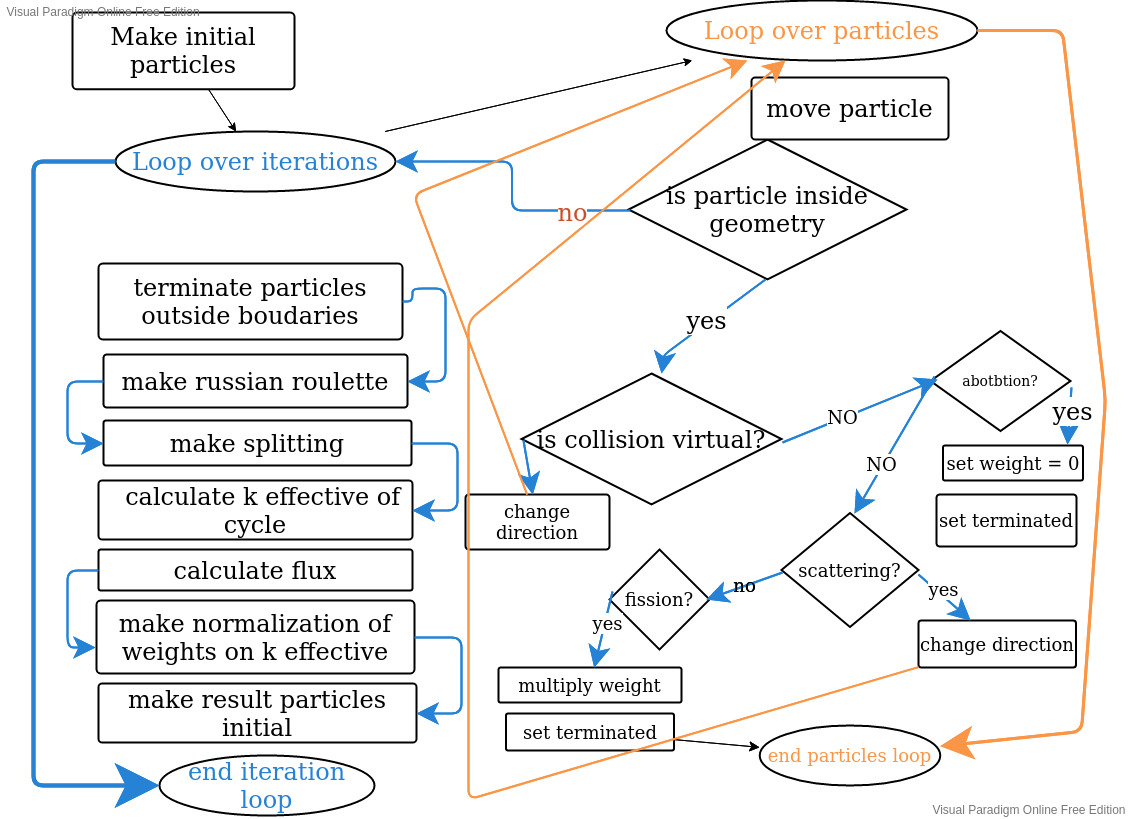

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import openmc
import openmc.mgxs as mgxs
import openmc.data
import random
import h5py
import copy

In [2]:
class Sig:
    def __init__(self):
        self.number_groups = 0
        self.sig_f = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []
        
    def __init__(self, number_groups, sig_f, sig_c, sig_s, number_of_production_neutrons, sig_t):
        self.number_groups = number_groups
        self.sig_f = sig_f
        self.sig_c = sig_c
        self.sig_s = sig_s      
        self.number_of_production_neutrons = number_of_production_neutrons
        self.sig_t = sig_t
        self.get_virtual_cs()
               
    def get_virtual_cs(self):
        max_total_cs = max(self.sig_t)
        self.virtual = [cross_section - max_total_cs for cross_section in self.sig_t]
        
    def get_fission_probability(self, energy_group_idx):
        return self.sig_f[energy_group_idx] / self.sig_t[energy_group_idx]
    
    def get_capture_probability(self, energy_group_idx):
        return self.sig_c[energy_group_idx] / self.sig_t[energy_group_idx]
        
    def get_scatter_probability(self, energy_group_idx):
        return self.sig_s[energy_group_idx] / self.sig_t[energy_group_idx]
        

In [3]:
cs_fission_pu_239 = [0.081600]

cs_fission_h2o = [0.0]

cs_capture_pu_239 = [0.019584]

cs_capture_h2o = [0.032640]

cs_scattering_pu_239 = [0.225216]

cs_scattering_h2o = [0.293760]

cs_total_pu_23 = [0.32640]

cs_total_h2o = [0.32640]

cs_production_neutrons_pu_239 = [3.24]
cs_production_neutrons_h2o = [0.0]

cs_c_value_pu_239 = [1.50]
cs_c_value_h2o = [0.90]

pu_23_cs_1_5 = Sig(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239, 
                       cs_production_neutrons_pu_239,  cs_total_pu_23)


h2o_cs = Sig(1, cs_fission_h2o, cs_capture_h2o, cs_scattering_h2o, 
                     cs_c_value_pu_239,  cs_total_h2o)

pu_h2o_CS_table_2 = {  
    "pu_23" : pu_23_cs_1_5,
    "h2o" : h2o_cs    
}

energy_groups_2 = [0, 2 * 1E10]

In [4]:
class Positon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

In [5]:
class Direction:
    def __init__(self, ets, phi):
        self.tetta_x = math.sin(ets) * math.cos(phi)
        self.tetta_y = math.sin(ets) * math.sin(phi)
        self.tetta_z = math.cos(ets)

In [6]:
class Particle:
    def __init__(self):
        self.coordinates = Positon(0, 0, 0)
        self.direction = Direction(0, 0)
        self.energy = 0
        self.weight = 1
        self.energy_groups = []
        self.terminated = False
        self.path = 0. 
        
    def set_coordinates(self, x, y, z):
        self.coordinates = Positon(x, y, z)
        
    def set_direction(self, ets, phi):
        self.direction = Direction(ets, phi)
    
    def set_direction_angle(self, angle):
        self.direction = angle
        
    def set_energy_groups(self, energy_groups):
        self.energy_groups = energy_groups
        
    def get_energy_group(self):  
        res = next(x for x, val in enumerate(self.energy_groups)
                                  if val > self.energy)        
        return res - 1
    
    def set_terminated(self):
        self.terminated = True
        
    def is_terminated(self):
        return self.terminated
        
    def get_weight(self):
        return self.weight
    
    def set_weight(self, weight):
        self.weight = weight
    
    def set_particle_deleted(self):
        self.weight = self.weight * 0
        
    def set_particle_fission(self, additional_weight):
        self.weight = self.weight * additional_weight
        
    def set_multiplicity(self, additional_weight):
        self.weight = self.weight * additional_weight
              
    def is_particle_deleted(self):
        return self.weight < 0.0001
    
    def add_path(self, path):
        self.path += path
    
    def get_path(self):
        return self.path
    
    def set_path(self, path):
        self.path = path
        
    def print_direction(self):
        print(str(self.direction.tetta_x) + " " + str(self.direction.tetta_y) + " " + str(self.direction.tetta_z))
        
    def print_coordinates(self):
        print(str(self.coordinates.x) + "  " + str(self.coordinates.y) + " " + str(self.coordinates.z))  
        

In [7]:
class Plane:
    def __init__(self, A, B, C, D):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        
    def distance(self, particle):
        vp = (self.A * particle.direction.tetta_x + self.B * particle.direction.tetta_y + 
              self.C * particle.direction.tetta_z)
        
        
        if (abs(vp) < 1e-9):
            return -1
        
        distance = (self.D - self.A * particle.coordinates.x - self.B * particle.coordinates.y 
                    - self.C * particle.coordinates.z) / vp
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        normal_sq = self.A * self.A + self.B * self.B + self.C * self.C
        
        x_numerator = 2 * self.A * (self.A * angle.tetta_x + self.B * angle.tetta_y +
                                 self.C * angle.tetta_z)
        
        y_numerator = 2 * self.B * (self.A * angle.tetta_x + self.B * angle.tetta_y +
                                 self.C * angle.tetta_z)
        
        z_numerator = 2 * self.C * (self.C * angle.tetta_x + self.B * angle.tetta_y +
                                 self.C * angle.tetta_z)
        
        
        r_reflected = Direction(0, 0)      
        r_reflected.tetta_x = angle.tetta_x - x_numerator / normal_sq
        r_reflected.tetta_y = angle.tetta_y - y_numerator / normal_sq
        r_reflected.tetta_z = angle.tetta_z - z_numerator / normal_sq
        
        return r_reflected
    
    def get_sign(self, particle):
      
        sign = (self.A * particle.coordinates.x + self.B * particle.coordinates.y +
        self.C * particle.coordinates.z - self.D)
        
        if sign == 0:
            return sign    
            
        if sign < 0:
            return -1
        else:
            return 1
        
    def get_xml(self):
        
        obj_xml = " Plane with A "+ str(self.A) + " B "+ str(self.B) + " C "+ str(self.C) + " D "+ str(self.D)
        
        return obj_xml
    

In [8]:
## Infinite cylinder parallel to z-axis

class ZCylinder:
    def __init__(self, x_0, y_0, r):
        self.x_0 = x_0
        self.y_0 = y_0
        self.r = r
        
    def distance(self, particle):
    
        a_ = particle.direction.tetta_x * particle.direction.tetta_x + (particle.direction.tetta_y * particle.direction.tetta_y )
        
        ## If a=0a 0a=0, this means the particle is parallel to the cylinder and will thus never intersect it
        if (abs(a_) < 1e-9):
            return -1
        
        c_ = ((particle.coordinates.x - self.x_0) * (particle.coordinates.x - self.x_0) + 
              (particle.coordinates.y - self.y_0) * (particle.coordinates.y - self.y_0) - self.r * self.r)

        k_ = (particle.coordinates.x -self.x_0) * particle.direction.tetta_x + (particle.coordinates.y -self.y_0) * particle.direction.tetta_y
        
        dec = k_ * k_ - a_ * c_
        
        if dec < 0:
            return -1
        
        dist_1 = (-k_ + math.sqrt(k_ * k_ - a_ * c_))/a_
        dist_2 = (-k_ - math.sqrt(k_ * k_ - a_ * c_))/a_
         
        distance = min(dist_1, dist_2)
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        
        eps = random.uniform(0, math.pi * 2)
        tetta = random.uniform(0, math.pi)
        r_reflected = Direction(eps, tetta)
        
        return r_reflected  
    
    def get_sign(self, particle):
            
        sign = ((self.x_0 - particle.coordinates.x) * (self.x_0 - particle.coordinates.x) + 
        (self.y_0 - particle.coordinates.y) * (self.y_0 - particle.coordinates.y) - self.r * self.r)
        
        if sign == 0:
            return 0
            
        if sign < 0:
            return -1
        else:
            return 1
        
    def get_xml(self):

        obj_xml = " ZCylinder with x_0 "+ str(x_0) + " y_0 "+ str(y_0) + " r = "+ str(r) 
        
        return obj_xml
    
    

In [9]:
class Sphere:
    def __init__(self, x_0, y_0, z_0, r):
        self.x_0 = x_0
        self.y_0 = y_0
        self.z_0 =z_0
        self.r = r
        
    def distance(self, particle):
    
       
        
        return distance
    
    
    def get_reflected_direction(self, angle):
        
        eps = random.uniform(0, math.pi * 2)
        tetta = random.uniform(0, math.pi)
        r_reflected = Direction(eps, tetta)
        
        return r_reflected  
    
    def get_sign(self, particle):
            
        sign = ((self.x_0 - particle.coordinates.x) * (self.x_0 - particle.coordinates.x) + 
        (self.y_0 - particle.coordinates.y) * (self.y_0 - particle.coordinates.y)  + 
                (self.z_0 - particle.coordinates.z) * (self.z_0 - particle.coordinates.z) - self.r * self.r)
        
        if sign == 0:
            return 0
            
        if sign < 0:
            return -1
        else:
            return 1  
        
    def get_xml(self):

        obj_xml = " Sphere with x_0 "+ str(x_0) + " y_0 "+ str(y_0) + " z_0 " + str(z_0) + " r = "+ str(r)
        
        return obj_xml
    

In [10]:
class Cell:
    def __init__(self):
        self.surfaces = []
        self.signs = []
        self.size = 0
        
    def __init__(self, surfaces, signs):
        self.surfaces = surfaces
        self.signs = signs
        self.size = len(self.signs)
        
    def is_inside(self, particle):
        
        is_inside = True
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                is_inside = False
                
        return is_inside  
    
    def get_minimum_distance(self, particle):
        
        minimum_distance = math.inf
        surface_idx = 0
        for i in range(0, len(self.surfaces)):
            current_distance = self.surfaces[i].distance(particle)
            if current_distance > 0:
                minimum_distance = min(minimum_distance, current_distance)
                surface_idx = i
        return minimum_distance, surface_idx
    
    def get_xml(self):
        
        xml_obj = []
        for i in range(0, self.size):
            xml_obj.append(surfaces[i].get_xml())
            
        return xml_obj
            
        

In [11]:
def set_random_direction(particle):
    r = 1.0
    r1 = 1.0
    while (r**2 + r1**2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.
        
    direction_x = 2.0 * r**2 + 2. * r1**2 - 1.0  
    particle.direction.tetta_x = direction_x
    particle.direction.tetta_y = r * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))
    particle.direction.tetta_z = r1 * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))


In [12]:
import random

def make_initial_sources(number_of_paricles, box_size, energy=10.0e6):
    
    step_x = 2 * box_size[0]/number_of_paricles
    step_y = 2 * box_size[1]/number_of_paricles
    step_z = 2 * box_size[2]/number_of_paricles
    
    x_coord = -box_size[0]
    y_coord = -box_size[1]
    z_coord = -box_size[2]
    
    sources = []
    for i in range(0, number_of_paricles):
        for j in range(0, number_of_paricles):
            for k in range(0, number_of_paricles):
                current_particle = Particle()
                current_particle.set_coordinates(x_coord + k * step_x, y_coord + j * step_y, z_coord+ i * step_z)
                set_random_direction(current_particle)
                current_particle.energy = energy
                current_particle.set_energy_groups(energy_groups_2)
                sources.append(current_particle)

    return sources

In [13]:
def get_free_path(particle, c_s):
    
    energy_group_idx = particle.get_energy_group()   
    sig_t = c_s.sig_t[energy_group_idx]
    free_path = -math.log(random.uniform(0, 1)) / sig_t
    
    return free_path  

In [14]:
def move_particle(particle, t):
    new_x = particle.direction.tetta_x * t + particle.coordinates.x
    new_y = particle.direction.tetta_y * t + particle.coordinates.y
    new_z = particle.direction.tetta_z * t + particle.coordinates.z
    particle.set_coordinates(new_x, new_y, new_z)

In [15]:
def is_collision_virual(particle, c_s):
    
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    virtual_cs = c_s.virtual[energy_group_idx]
    total_cs = c_s.sig_t[energy_group_idx]
    if virtual_cs / total_cs >= random_number:
        return True
    else:
        return False

In [16]:
def process_virtual_collision(particle, free_path):
    particle.add_path(free_path)
    

In [17]:
def process_real_collision(particle, free_path, universe, c_s):
    
    energy_group_idx = particle.get_energy_group()
    weight_before_collision = particle.get_weight()
    number_of_production_neutrons = c_s.number_of_production_neutrons[energy_group_idx]   
    capture_probability = c_s.get_capture_probability(energy_group_idx)
    scatter_probability = c_s.get_scatter_probability(energy_group_idx)  
    fission_probability = c_s.get_fission_probability(energy_group_idx)  
    
    
    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                            fission_probability])
    if type_collision == 'capture':
        particle.set_terminated()
        particle.set_weight(0.)
        
    if type_collision == 'scatter':      
        set_random_direction(particle)
        
    if type_collision == 'fission':    
        particle.set_particle_fission(number_of_production_neutrons)
        particle.set_terminated()
        
    return weight_before_collision
        

In [18]:
def delete_absorpbed_paricles(particles):
    
    existing_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        if particle.get_weight() > 0.000001:
            existing_particles.append(particle)
                     
    return existing_particles

In [22]:
def process_one_particle_history_black_boundary(particle, universe, c_s):
    
    sum_collisions = 0.
    while not particle.is_terminated():
        
        free_path = get_free_path(particle, c_s)
        set_random_direction(particle)

        move_particle(particle, free_path)
        if not universe.is_inside(particle):
            print("particle is outside  ")
            particle.set_weight(0.)
            particle.set_terminated()
            break
            
        if is_collision_virual(particle, c_s):
            process_virtual_collision(particle, free_path)
        else:
            sum_collisions += process_real_collision(particle, free_path, universe, c_s)
        
            
    return particle, sum_collisions

In [23]:
def get_weights(particles):
    
    weights = []
    for i in range(0, len(particles)):
        weights.append(particles[i].weight)
        
    return weights

In [24]:
def make_sources(particles):
    for i in range(0, len(particles)):
        particles[i].terminated = False


In [25]:
def splitting_secound_version(particles):
    
    
    initial_size = len(particles)
    
    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)
            random_value = random.uniform(0, 1)
            if current_weight - n_value >= random_value:
                n_value += 1
            if n_value > 1:
                particle.set_weight(current_weight / n_value)
                for j in range(0, n_value - 1):
                    particles.append(copy.deepcopy(particle))
                    

In [26]:
def splitting_without_random(particles):
     
    initial_size = len(particles)
    
    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)          
            particle.set_weight(current_weight / n_value)
            for j in range(0, n_value - 2):
                particles.append(copy.deepcopy(particle))
            additonal_particle = copy.deepcopy(particle)
            additonal_particle.set_weight(current_weight - n_value)
            particles.append(additonal_particle)
                    
    

In [27]:
def normalise_weights(particles, batch_size):

    sum_weights = 0.
    
    for i in range(0, len(particles)):
        sum_weights += particles[i].get_weight()

    for i in range(0, len(particles)):
        particles[i].weight = (particles[i].weight * batch_size) / sum_weights   
        
    return particles

In [28]:
def russian_roulette(weights_previous, particles_current):
    
    for i in range(0, len(particles_current)):
        particle = particles_current[i]
        if particle.weight > 0 and particle.weight < 0.5 and particle.weight < weights_previous[i]:
            probability_terminate = 1. - particle.weight / weights_previous[i]
            random_number = random.uniform(0, 1)
            if probability_terminate >= random_number:
                particle.set_weight(0.)
            else:
                particle.set_weight(weights_previous[i])


In [29]:
def flux_estimator(cell_volume, start_weight, particles_current_iteration, cross_section):
    
    sum_weighted_paths = 0.
    
    for i in range(0, len(particles_current_iteration)):
        particle = particles_current_iteration[i]
        energy_group_idx = particle.get_energy_group() 
  
        number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
        sum_weighted_paths += particles_current_iteration[i].get_weight()* (
            particles_current_iteration[i].get_path())
        
    total_flux = sum_weighted_paths/(cell_volume * start_weight)
    
    return total_flux
    

In [30]:
def terminate_outside_particles(batch_particles, universe):
    
    for j in range(0, len(batch_particles)):
        particle = batch_particles[j]
        if not universe.is_inside(particle):
            particle.set_weight(0.)

In [33]:
def calculate_k_effective(idx, weights, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, std_k_effective):
    
    keff_cycle = sum(weights) / initial_size
    if idx > number_inactive:
        k_effective.append(keff_cycle)
    
        k_effective_exp.append(sum(k_effective) / len(k_effective))
        
            

In [34]:
def calculate_flux(weight_previos, volume, sum_collisions, c_s):
    
    sig_t = c_s.sig_t[0]
    flux = sum_collisions / ( sum(weight_previos) * volume * sig_t)

In [35]:
import statistics
import time


def simulation_black_boundaries(universe, number_interations, number_inactive, number_of_particles, c_s, volume=1):
    
    random.seed(time.time())
    k_effective = []
    k_effective_std = []
    k_effective_exp = []
    num1 = random.randint(0,9)
    
    print(" num1  " + str(num1))
    
    initial_sources = make_initial_sources(number_of_particles, energy=10.0e6, box_size=[0.5, 0.5, 0.5])
    initial_size = len(initial_sources)
    
    weights_previous = [1.] * len(initial_sources)
    
    for i in range(0, number_interations):
        print("i == " + str(i))
        
        make_sources(initial_sources)
        batch_size = len(initial_sources)
        
        batch_particles = []
        total_collisions = 0.

        for j in range(0, batch_size):
            
            particle = initial_sources[j]
            terminate_particle, sum_collisions = process_one_particle_history_black_boundary(particle, universe, c_s)
            batch_particles.append(terminate_particle)
            total_collisions += sum_collisions
        
        russian_roulette(weights_previous, batch_particles)
        
        batch_particles = delete_absorpbed_paricles(batch_particles)
        
        splitting_secound_version(batch_particles)
        
        weights_cycle = get_weights(batch_particles)
        
        calculate_k_effective(i, weights_cycle, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, k_effective_std)
        

        batch_particles = normalise_weights(batch_particles, initial_size) 
        

        initial_sources = batch_particles
        weights_previous = get_weights(batch_particles)

            
    return k_effective, k_effective_exp, k_effective_std

In [37]:
x_5 = Plane(0, 1, 0, 500)
x_m5 = Plane(0, 1, 0, -500)

y_5 = Plane(1, 0, 0, 1.853722)
y_m5 = Plane(1, 0, 0, -1.853722)

y_5 = Plane(1, 0, 0, 500)
y_m5 = Plane(1, 0, 0, -500)


z_5 = Plane(0, 0, 1, 500)
z_m5 = Plane(0, 0, 1, -500)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_2 = Cell(surfaces, signs)

In [38]:
def save_simulation_results_to_file(number_of_particles, number_interations, number_inactive,
                                   universe, k_effective, k_effective_exp, k_effective_std, file_name):
    
    f = open(file_name, "w")
    f.write("number of particles  " + str(number_of_particles) + "\n")
    f.write("number of interations  " + str(number_interations) + "\n")
    f.write("number inactive  " + str(number_inactive) + "\n")
    universe_discription = universe.get_xml()
    f.write("geometry \n")
    for xml_cell in universe_discription:
        f.write(xml_cell + "\n")
    
    for i in range(0, len(k_effective)):
        f.write(" cycle k effective "+ str(k_effective[i]) + "  average k effective "+ str(k_effective_exp[i]) + "  std "+ 
                str(k_effective_std[i]) + '\n')
            
    
    f.close()

In [39]:
test_number_of_particles = 20
test_number_interations = 1000
test_number_inactive = 100


k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_2,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_5)

 num1  4
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
i == 52
i == 53
i == 54
i == 55
i == 56
i == 57
i == 58
i == 59
i == 60
i == 61
i == 62
i == 63
i == 64
i == 65
i == 66
i == 67
i == 68
i == 69
i == 70
i == 71
i == 72
i == 73
i == 74
i == 75
i == 76
i == 77
i == 78
i == 79
i == 80
i == 81
i == 82
i == 83
i == 84
i == 85
i == 86
i == 87
i == 88
i == 89
i == 90
i == 91
i == 92
i == 93
i == 94
i == 95
i == 96
i == 97
i == 98
i == 99
i == 100
i == 101
i == 102
i == 103
i == 104
i == 105
i == 106
i == 107
i == 108
i == 109
i == 110
i == 111
i == 112
i == 113
i == 114
i == 115
i == 116
i == 117
i == 118
i == 119
i == 120
i == 121
i =

i == 880
i == 881
i == 882
particle is outside  
i == 883
i == 884
particle is outside  
i == 885
i == 886
i == 887
i == 888
i == 889
i == 890
i == 891
i == 892
i == 893
i == 894
i == 895
i == 896
particle is outside  
i == 897
i == 898
particle is outside  
i == 899
i == 900
i == 901
i == 902
i == 903
i == 904
i == 905
particle is outside  
i == 906
i == 907
i == 908
particle is outside  
particle is outside  
i == 909
particle is outside  
i == 910
i == 911
i == 912
i == 913
i == 914
i == 915
i == 916
i == 917
i == 918
i == 919
i == 920
particle is outside  
i == 921
i == 922
i == 923
i == 924
i == 925
i == 926
i == 927
i == 928
i == 929
i == 930
particle is outside  
i == 931
i == 932
i == 933
i == 934
i == 935
i == 936
i == 937
i == 938
i == 939
i == 940
i == 941
i == 942
i == 943
i == 944
i == 945
i == 946
particle is outside  
i == 947
i == 948
i == 949
i == 950
i == 951
particle is outside  
i == 952
i == 953
particle is outside  
i == 954
i == 955
i == 956
i == 957
particle is 

In [398]:
test_number_of_particles = 20
test_number_interations = 1000
test_number_inactive = 100
file_name = "test.txt"

save_simulation_results_to_file(test_number_of_particles, test_number_interations, test_number_inactive,
                                   slab_2, k_effective, k_effective_exp, k_effective_std, file_name)

In [ ]:
iterations =range(0, len(n_k_effective))

In [32]:
2.612903
#2.61448639866804
difference = (k_effective_exp[-1] - 2.612903) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  26.24910600701469  with standart deviation [pcm]+- 0.02702162316256847


In [89]:
def generate_average_k_effective(k_effective, iterations_skip):
    
    k_effective_active = k_effective[iterations_skip:]
    
    average_k_effective = []
    
    for i in range(1, len(k_effective_active)):
        average_k_effective.append(sum(k_effective_active[:i]) / i)
        
    average_k_effective = np.array(average_k_effective) - 2.612903
        
    return average_k_effective
        
    

In [414]:
average_100 = generate_average_k_effective(k_effective, 100)
print(len(average_100))
iterations_100 =range(100, len(average_100) + 100)

798


In [415]:
average_200 = generate_average_k_effective(k_effective, 200)
print(len(average_200))
iterations_200 =range(200, len(average_200) + 200)

698


In [416]:
average_300 = generate_average_k_effective(k_effective, 300)
print(len(average_300))
iterations_300 =range(300, len(average_300) + 300)

598


In [417]:
average_400 = generate_average_k_effective(k_effective, 400)
print(len(average_400))
iterations_400 =range(400, len(average_400) + 400)

498


In [423]:
average_500 = generate_average_k_effective(k_effective, 500)
print(len(average_500))
iterations_500 =range(500, len(average_500) + 500)

398


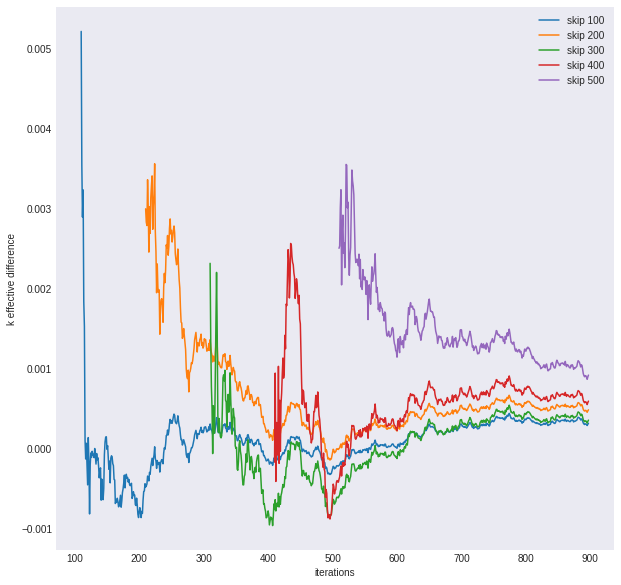

In [424]:

import matplotlib
plt.figure(figsize=(10, 10))
plt.xlabel("iterations")
plt.ylabel("k effective difference")


plt.plot(iterations_100[10:], average_100[10:], label='skip 100')
plt.plot(iterations_200[10:], average_200[10:], label='skip 200')
plt.plot(iterations_300[10:], average_300[10:], label='skip 300')
plt.plot(iterations_400[10:], average_400[10:], label='skip 400')
plt.plot(iterations_500[10:], average_500[10:], label='skip 500')
plt.legend()

In [28]:
iterations
n_k_effective = (np.array(k_effective_exp) - 2.612903) * 100000

NameError: name 'iterations' is not defined

In [368]:
iterations100 =  iterations[100:]
n_k_effective100 = (np.array(k_effective_exp[100:]) - 2.612903) * 100000

In [343]:
iterations200 =  iterations[200:]
n_k_effective200 = (np.array(k_effective_exp[200:]) - 2.612903) * 100000

In [344]:
iterations300 =  iterations[300:]
n_k_effective300 = (np.array(k_effective_exp[300:]) - 2.612903) * 100000

In [345]:
iterations400 =  iterations[400:]
n_k_effective400 = (np.array(k_effective_exp[400:]) - 2.612903) * 100000

In [346]:
iterations500 =  iterations[500:]
n_k_effective500 = (np.array(k_effective_exp[500:]) - 2.612903) * 100000

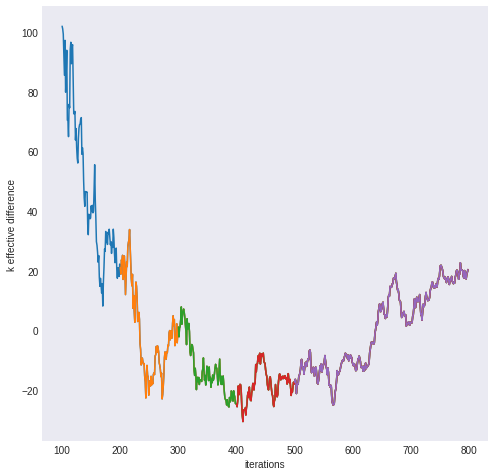

In [350]:
iterations =range(0, len(n_k_effective))
import matplotlib
plt.figure(figsize=(8, 8))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

#plt.plot(iterations, n_k_effective)
plt.plot(iterations100, n_k_effective100)
plt.plot(iterations200, n_k_effective200)
plt.plot(iterations300, n_k_effective300)
plt.plot(iterations400, n_k_effective400)
plt.plot(iterations500, n_k_effective500)

In [366]:
test_number_of_particles = 20
test_number_interations = 1000
test_number_inactive = 500


k_effective1, k_effective_exp1, k_effective_std1 = simulation_black_boundaries(slab_2,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_5)

 num1  8
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
i == 52
i == 53
i == 54
i == 55
i == 56
i == 57
i == 58
i == 59
i == 60
i == 61
i == 62
i == 63
i == 64
i == 65
i == 66
i == 67
i == 68
i == 69
i == 70
i == 71
i == 72
i == 73
i == 74
i == 75
i == 76
i == 77
i == 78
i == 79
i == 80
i == 81
i == 82
i == 83
i == 84
i == 85
i == 86
i == 87
i == 88
i == 89
i == 90
i == 91
i == 92
i == 93
i == 94
i == 95
i == 96
i == 97
i == 98
i == 99
i == 100
i == 101
i == 102
i == 103
i == 104
i == 105
i == 106
i == 107
i == 108
i == 109
i == 110
i == 111
i == 112
i == 113
i == 114
i == 115
i == 116
i == 117
i == 118
i == 119
i == 120
i == 121
i =

 keff_cycle , k_effective_exp, std_k_effective 2.6095808424354874   2.6136037170885507  1.6491019520040678e-07
i == 535
 keff_cycle , k_effective_exp, std_k_effective 2.619254829646839   2.613765177447359  1.6544641015303433e-07
i == 536
 keff_cycle , k_effective_exp, std_k_effective 2.62307276626095   2.6140237215810695  1.6790731284453557e-07
i == 537
 keff_cycle , k_effective_exp, std_k_effective 2.619411609506524   2.6141693401736497  1.6829788989335256e-07
i == 538
 keff_cycle , k_effective_exp, std_k_effective 2.616525139643214   2.614231334896533  1.6786519534561154e-07
i == 539
 keff_cycle , k_effective_exp, std_k_effective 2.6193716474259734   2.614363137781903  1.6815516207494573e-07
i == 540
 keff_cycle , k_effective_exp, std_k_effective 2.617035222967946   2.6144299399115543  1.6777743730223354e-07
i == 541
 keff_cycle , k_effective_exp, std_k_effective 2.60239565927392   2.614136420871612  1.7203791792782643e-07
i == 542
 keff_cycle , k_effective_exp, std_k_effective 2.622

 keff_cycle , k_effective_exp, std_k_effective 2.6228972722195136   2.6137533757937566  2.3729585776580325e-07
i == 605
 keff_cycle , k_effective_exp, std_k_effective 2.6269205933366684   2.613878777865594  2.392146851059265e-07
i == 606
 keff_cycle , k_effective_exp, std_k_effective 2.6124831048620165   2.6138656111391447  2.3845529899488093e-07
i == 607
 keff_cycle , k_effective_exp, std_k_effective 2.610441245015309   2.6138336077174267  2.3785016172748068e-07
i == 608
 keff_cycle , k_effective_exp, std_k_effective 2.6144302528035968   2.613839132208965  2.3707322123112636e-07
i == 609
 keff_cycle , k_effective_exp, std_k_effective 2.606865359627457   2.6137751526439974  2.3703720501879946e-07
i == 610
 keff_cycle , k_effective_exp, std_k_effective 2.6070388177182497   2.6137139132355816  2.369485819130575e-07
i == 611
 keff_cycle , k_effective_exp, std_k_effective 2.6139451710823827   2.6137159966396064  2.3617378052472746e-07
i == 612
 keff_cycle , k_effective_exp, std_k_effective

 keff_cycle , k_effective_exp, std_k_effective 2.6270941470533047   2.6132170555345495  2.510441229472596e-07
i == 675
 keff_cycle , k_effective_exp, std_k_effective 2.6093875225835452   2.6131951724891147  2.504409781425528e-07
i == 676
 keff_cycle , k_effective_exp, std_k_effective 2.6157566389455686   2.6132097262757994  2.4976276187768796e-07
i == 677
 keff_cycle , k_effective_exp, std_k_effective 2.6099225239181045   2.6131911545110666  2.4912789173492907e-07
i == 678
 keff_cycle , k_effective_exp, std_k_effective 2.615848676264351   2.613206084408557  2.4846008879026516e-07
i == 679
 keff_cycle , k_effective_exp, std_k_effective 2.615782871143422   2.6132204798651766  2.477911206107297e-07
i == 680
 keff_cycle , k_effective_exp, std_k_effective 2.618450991257915   2.613249538261803  2.4732045892579567e-07
i == 681
 keff_cycle , k_effective_exp, std_k_effective 2.6169380590999993   2.6132699168299696  2.467220111701777e-07
i == 682
 keff_cycle , k_effective_exp, std_k_effective 2.

 keff_cycle , k_effective_exp, std_k_effective 2.6092268503112215   2.6136626785918757  2.4358362434338984e-07
i == 745
 keff_cycle , k_effective_exp, std_k_effective 2.5855458911417455   2.6135479161941197  2.48148216041315e-07
i == 746
 keff_cycle , k_effective_exp, std_k_effective 2.625254840452013   2.6135955053171194  2.4837412846358837e-07
i == 747
 keff_cycle , k_effective_exp, std_k_effective 2.609331162831483   2.613578240772643  2.478268298493865e-07
i == 748
 keff_cycle , k_effective_exp, std_k_effective 2.6247192825623116   2.6136231643282466  2.479639056513773e-07
i == 749
 keff_cycle , k_effective_exp, std_k_effective 2.6170684000163495   2.613637000616151  2.47377923360194e-07
i == 750
 keff_cycle , k_effective_exp, std_k_effective 2.613521601236417   2.613636539018632  2.467183340800862e-07
i == 751
 keff_cycle , k_effective_exp, std_k_effective 2.6182229339937657   2.613654811508573  2.4619545212417084e-07
i == 752
 keff_cycle , k_effective_exp, std_k_effective 2.60639

 keff_cycle , k_effective_exp, std_k_effective 2.6112354852480744   2.613830418147832  2.383217784089512e-07
i == 815
 keff_cycle , k_effective_exp, std_k_effective 2.6188075176801986   2.6138462184638076  2.378549101604368e-07
i == 816
 keff_cycle , k_effective_exp, std_k_effective 2.626517632241302   2.613886317874496  2.380333194592908e-07
i == 817
 keff_cycle , k_effective_exp, std_k_effective 2.611117584614669   2.613877583700175  2.3748682027606302e-07
i == 818
 keff_cycle , k_effective_exp, std_k_effective 2.6157417355681325   2.6138834458129674  2.3692253692210118e-07
i == 819
 keff_cycle , k_effective_exp, std_k_effective 2.621877989662595   2.6139085070789534  2.366440944681829e-07
i == 820
 keff_cycle , k_effective_exp, std_k_effective 2.6050892918593798   2.6138809470313924  2.364307495363595e-07
i == 821
 keff_cycle , k_effective_exp, std_k_effective 2.6335882670628914   2.61394234055174  2.3765886228334906e-07
i == 822
 keff_cycle , k_effective_exp, std_k_effective 2.6256

 keff_cycle , k_effective_exp, std_k_effective 2.6104045879310656   2.6140169890497824  2.2527793467135362e-07
i == 885
 keff_cycle , k_effective_exp, std_k_effective 2.618012260116607   2.6140273663772287  2.248266881998362e-07
i == 886
 keff_cycle , k_effective_exp, std_k_effective 2.606992552462276   2.614009141470713  2.2449805600899623e-07
i == 887
 keff_cycle , k_effective_exp, std_k_effective 2.6160250372236526   2.6140143505036666  2.2400650916731717e-07
i == 888
 keff_cycle , k_effective_exp, std_k_effective 2.6135189316087724   2.6140130736508445  2.2350287275501936e-07
i == 889
 keff_cycle , k_effective_exp, std_k_effective 2.6085144311539925   2.6139989383230895  2.2310852749584583e-07
i == 890
 keff_cycle , k_effective_exp, std_k_effective 2.600159546631711   2.6139634527033677  2.232915430798821e-07
i == 891
 keff_cycle , k_effective_exp, std_k_effective 2.605587141978597   2.6139420299137903  2.2303995269462771e-07
i == 892
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 2.6268120966483304   2.613867057435504  2.0958784983853815e-07
i == 955
 keff_cycle , k_effective_exp, std_k_effective 2.621642854991443   2.613884147100462  2.0932260845340147e-07
i == 956
 keff_cycle , k_effective_exp, std_k_effective 2.619006004373735   2.613895379243605  2.0895985114607033e-07
i == 957
 keff_cycle , k_effective_exp, std_k_effective 2.606418253421691   2.6138790179179554  2.0868289862155608e-07
i == 958
 keff_cycle , k_effective_exp, std_k_effective 2.5994542373350598   2.613847522763844  2.0883946156681032e-07
i == 959
 keff_cycle , k_effective_exp, std_k_effective 2.610924387628763   2.613841154277711  2.0842815945445836e-07
i == 960
 keff_cycle , k_effective_exp, std_k_effective 2.622913250436003   2.6138608762258815  2.0822672546747223e-07
i == 961
 keff_cycle , k_effective_exp, std_k_effective 2.6171930100502134   2.6138681042818996  2.07824690938228e-07
i == 962
 keff_cycle , k_effective_exp, std_k_effective 2.619

In [8]:
1000

difference = (2.612870250027125 - 2.612903) * 100000

standart_deviation = 1.521954068313456e-07 * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -3.2749972875389943  with standart deviation [pcm]+- 0.01521954068313456


In [ ]:
average k effective 2.6129587755379324  std 5.286662293366592e-08

In [9]:
2000

difference = (2.6129587755379324 - 2.612903) * 100000

standart_deviation = 5.286662293366592e-08 * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  5.577553793223444  with standart deviation [pcm]+- 0.0052866622933665924


In [ ]:
verage k effective 2.6128999425215755  std 1.904570384854544e-08

In [10]:
4000

difference = (2.612899 - 2.612903) * 100000

standart_deviation = 1.904570384854544e-08 * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -0.40000000001150227  with standart deviation [pcm]+- 0.0019045703848545438


In [324]:
n_k_effective = (np.array(k_effective_exp) - 2.612903) * 100000

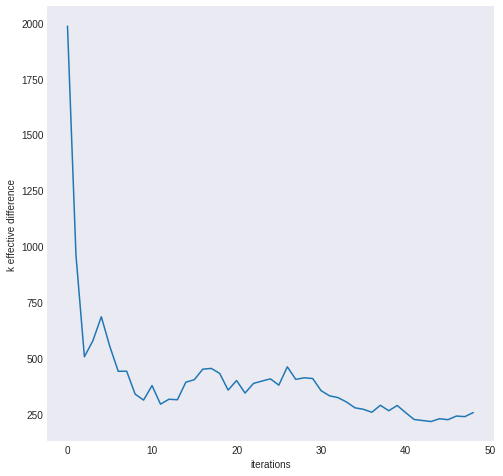

In [321]:
iterations =range(0, len(n_k_effective))
import matplotlib
plt.figure(figsize=(8, 8))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

plt.plot(iterations, n_k_effective)

In [322]:
2.612903
#2.61448639866804
difference = (k_effective_exp[-1] - 2.612903) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  255.56455537731892  with standart deviation [pcm]+- 0.6118934944796822


In [293]:
n_k_effective = (np.array(k_effective_exp) - 2.612903) * 100000

In [1]:
iterations =range(0, len(n_k_effective))
import matplotlib
plt.figure(figsize=(8, 8))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

plt.plot(iterations, n_k_effective)


NameError: name 'n_k_effective' is not defined

(array([ 1.,  3.,  6., 23., 12.,  0.,  1.,  1.,  0.,  2.]),
 array([-517.30062152, -452.8155558 , -388.33049007, -323.84542435,
        -259.36035863, -194.87529291, -130.39022718,  -65.90516146,
          -1.42009574,   63.06496998,  127.5500357 ]),
 <BarContainer object of 10 artists>)

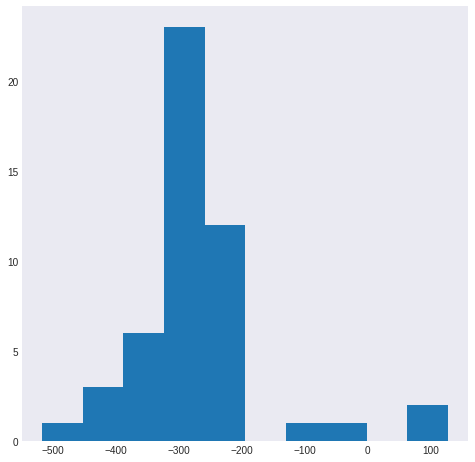

In [305]:
plt.figure(figsize=(8, 8))
matplotlib.pyplot.hist(n_k_effective)

In [306]:
from scipy.stats import norm

In [ ]:
k_effective

In [308]:
norm.pdf(k_effective_exp)

array([0.0126363 , 0.01322734, 0.01318635, 0.01315937, 0.01320217,
       0.01331768, 0.01325115, 0.01327281, 0.01318384, 0.01315411,
       0.01316375, 0.01316624, 0.01319733, 0.01318884, 0.01318762,
       0.01313092, 0.01312874, 0.01314527, 0.01315518, 0.01316045,
       0.01313891, 0.01313304, 0.01314408, 0.01314259, 0.01314262,
       0.01315206, 0.01312712, 0.01311783, 0.01310681, 0.01308819,
       0.0130934 , 0.01309641, 0.01309787, 0.01308297, 0.01307914,
       0.01307618, 0.01305468, 0.01304188, 0.01303227, 0.01304011,
       0.01304453, 0.0130549 , 0.01305523, 0.01305877, 0.01306748,
       0.01305511, 0.0130442 , 0.01305588, 0.01306566])

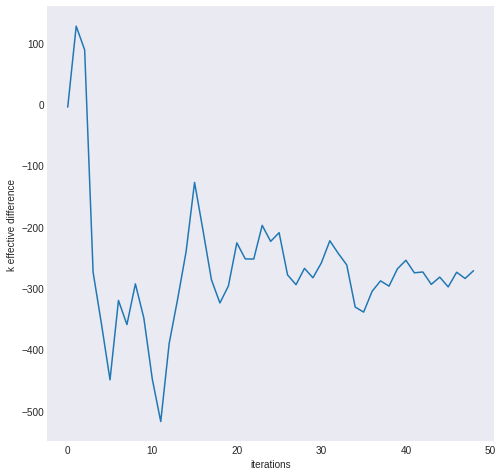

In [309]:
iterations = range(0, len(n_k_effective))
import matplotlib
plt.figure(figsize=(8, 8))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

plt.plot(iterations, n_k_effective)


In [7]:
 2.612903 * 100000

261290.30000000002

In [6]:
2.612903
#2.61448639866804
difference = (2.612870250027125 - 2.612903) * 100000

standart_deviation = 1.521954068313456e-07 * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -3.2749972875389943  with standart deviation [pcm]+- 0.01521954068313456


In [65]:
x_5 = Plane(0, 1, 0, 500)
x_m5 = Plane(0, 1, 0, -500)

y_5 = Plane(1, 0, 0, 1.853722)
y_m5 = Plane(1, 0, 0, -1.853722)


z_5 = Plane(0, 0, 1, 500)
z_m5 = Plane(0, 0, 1, -500)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_2 = Cell(surfaces, signs)


In [68]:
test_number_of_particles = 20
test_number_interations = 100
test_number_inactive = 50


k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_2,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_5)

i == 0
 total_collision 10819.0
flux   4.143305759803921
i == 1
 total_collision 10229.577290194487
flux   3.9175770872373796
i == 2
 total_collision 9940.961083568229
flux   3.8070469835972967
i == 3
 total_collision 9905.146459817772
flux   3.7933312116329403
i == 4
 total_collision 9933.466752996781
flux   3.8041769121466484
i == 5
 total_collision 9923.497249942082
flux   3.8003589345668845
i == 6
 total_collision 9971.926289103274
flux   3.8189055947851744
i == 7
 total_collision 9869.329172985623
flux   3.7796144198009824
i == 8
 total_collision 9887.801381394695
flux   3.78668864177199
i == 9
 total_collision 9689.072844412913
flux   3.710582431223945
i == 10
 total_collision 9751.838083829838
flux   3.734619364211445
i == 11
 total_collision 9797.600378000308
flux   3.75214475260379
i == 12
 total_collision 9948.925241732619
flux   3.8100969828939797
i == 13
 total_collision 9863.58160319016
flux   3.777413297790283
i == 14
 total_collision 9764.504590074599
flux   3.7394702014

 keff_cycle , k_effective_exp, std_k_effective 1.0090800040820946   1.0044328282585568  1.4826946334102372e-05
 total_collision 9928.181416469259
flux   3.802152809615904
i == 79
 keff_cycle , k_effective_exp, std_k_effective 1.0068937065081225   1.0045176861292315  1.4049499822471237e-05
 total_collision 9799.150867431725
flux   3.752738536853416
i == 80
 keff_cycle , k_effective_exp, std_k_effective 0.9939245605022726   1.0041645819416662  1.6279318671977334e-05
 total_collision 9714.592204165592
flux   3.7203554703451385
i == 81
 keff_cycle , k_effective_exp, std_k_effective 0.9749055095746636   1.0032207408975695  2.8085759227679918e-05
 total_collision 9651.204972729152
flux   3.6960803357571
i == 82
 keff_cycle , k_effective_exp, std_k_effective 1.0014854310675678   1.003166512465382  1.3767099569346878e-05
 total_collision 9948.594024509033
flux   3.8099701380625697
i == 83
 keff_cycle , k_effective_exp, std_k_effective 0.9967908220796818   1.0029733097264213  1.4374915170203725

In [69]:
difference = (1.0 - k_effective_exp[-1]) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -43.505983967873085  with standart deviation [pcm]+- 2.4726621156699924


In [70]:
cs_fission_pu_239 = [0.081600]

cs_fission_h2o = [0.0]

cs_capture_pu_239 = [0.019584]

cs_capture_h2o = [0.032640]

cs_scattering_pu_239 = [0.225216]

cs_scattering_h2o = [0.293760]

cs_total_pu_23 = [0.32640]

cs_total_h2o = [0.32640]

cs_production_neutrons_pu_239 = [2.84]
cs_production_neutrons_h2o = [0.0]


pu_23_cs_1_4 = Sig(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239, 
                       cs_production_neutrons_pu_239,  cs_total_pu_23)


h2o_cs = Sig(1, cs_fission_h2o, cs_capture_h2o, cs_scattering_h2o, 
                     cs_c_value_pu_239,  cs_total_h2o)

pu_h2o_CS_table_2 = {  
    "pu_23" : pu_23_cs_1_4,
    "h2o" : h2o_cs    
}

energy_groups_2 = [0, 2 * 1E10]

In [35]:
x_5 = Plane(0, 1, 0, 500)
x_m5 = Plane(0, 1, 0, -500)

y_5 = Plane(1, 0, 0, 500)
y_m5 = Plane(1, 0, 0, -500)



z_5 = Plane(0, 0, 1, 500)
z_m5 = Plane(0, 0, 1, -500)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_3 = Cell(surfaces, signs)

In [36]:
test_number_of_particles = 20
test_number_interations = 70
test_number_inactive = 50


k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_3,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4)

i == 0
 total_collision 25597.0
flux   9.802772671568626
i == 1
 total_collision 25876.288659796304
flux   9.909730644839454
i == 2
 total_collision 25966.11695116664
flux   9.9441317980904
i == 3
 total_collision 25586.43120821346
flux   9.798725186973149
i == 4


KeyboardInterrupt: 

In [630]:
difference = (2.290323  - k_effective_exp[-1]) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -170.98729644939857  with standart deviation [pcm]+- 0.5472847568782455


In [71]:
x_5 = Plane(0, 1, 0, 500)
x_m5 = Plane(0, 1, 0, -500)

y_5 = Plane(1, 0, 0, 2.256751)
y_m5 = Plane(1, 0, 0, -2.256751)



z_5 = Plane(0, 0, 1, 500)
z_m5 = Plane(0, 0, 1, -500)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_3 = Cell(surfaces, signs)

In [74]:
test_number_of_particles = 20
test_number_interations = 70
test_number_inactive = 50


k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_3,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4)

i == 0
 total_collision 12404.0
flux   4.750306372549019
i == 1
 total_collision 11619.783285054631
flux   4.449978280122919
i == 2
 total_collision 11343.586650584051
flux   4.344204446454349
i == 3
 total_collision 11249.313353961512
flux   4.30810100871682
i == 4
 total_collision 11302.13215321873
flux   4.328328796422733
i == 5
 total_collision 11393.652195617306
flux   4.363377832268364
i == 6
 total_collision 11466.229680504486
flux   4.391172518575143
i == 7
 total_collision 11132.848686864556
flux   4.26349903755461
i == 8
 total_collision 11267.648247669835
flux   4.3151226438685395
i == 9
 total_collision 11382.689585455824
flux   4.359179528744086
i == 10
 total_collision 11197.840025501646
flux   4.288388490158799
i == 11
 total_collision 11386.193656561181
flux   4.360521467738732
i == 12
 total_collision 11212.631022426182
flux   4.294052934446192
i == 13
 total_collision 11088.218695228277
flux   4.246407282180317
i == 14
 total_collision 11285.485155611099
flux   4.3219

In [73]:
difference = (1.0 - k_effective_exp[-1]) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -573.7239929471727  with standart deviation [pcm]+- 1.4736216596405267


In [634]:
test_cylinder = ZCylinder(0, 0, 4.279960)

plane_5 = Plane(0, 0, 1, 500)
plane_6 = Plane(0, 0, 1, -500)

surfaces = [test_cylinder, plane_5, plane_6]
signs = [-1, -1, +1]

cylinder = Cell(surfaces, signs)

k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(cylinder,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4)

i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
 keff_cycle , k_effective_exp, std_k_effective 1.0152867201893798   1.0152867201893798  0.0
i == 52
 keff_cycle , k_effective_exp, std_k_effective 0.9962991920695051   1.0057929561294425  7.159701402667684e-06
i == 53
 keff_cycle , k_effective_exp, std_k_effective 1.0138145170808686   1.0084668097799179  6.377752952722419e-06
i == 54
 keff_cycle , k_effective_exp, std_k_effective 0.9985004364292709   1.005975216442256  7.976456826426039e-06
i == 55
 keff_cycle , k_effective_exp, std_k_effective 1.001297520513609   1.0050396772565267  6.608080818746331e-06
i == 56
 keff_cycle , k_effectiv

In [635]:
difference = (1.0 - k_effective_exp[-1]) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -34.57443588572584  with standart deviation [pcm]+- 2.432355037492784


In [84]:
test_sphere = Sphere(0, 0, 0, 6.082547)


surfaces = [test_sphere]
signs = [-1]

sphere = Cell(surfaces, signs)

k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(sphere,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4)

i == 0
 total_collision 15076.0
flux   5.773590686274509
i == 1
 total_collision 13038.382758927008
flux   4.9932532011834745
i == 2
 total_collision 12149.063832860576
flux   4.65267456834582
i == 3
 total_collision 11728.184216836764
flux   4.491492117355649
i == 4
 total_collision 11520.243491208417
flux   4.411857954660113
i == 5
 total_collision 11347.201121183603
flux   4.3455886646680515
i == 6
 total_collision 11410.270885568867
flux   4.369742220270992
i == 7
 total_collision 11286.179375341067
flux   4.3222194298946786
i == 8
 total_collision 11454.89866854525
flux   4.38683312980459
i == 9
 total_collision 11308.963613706625
flux   4.330945011375766
i == 10
 total_collision 11092.350408521526
flux   4.247989586596979
i == 11
 total_collision 11349.20804179968
flux   4.346357246399983
i == 12
 total_collision 11239.182647958234
flux   4.3042212959398345
i == 13
 total_collision 11362.262430277604
flux   4.351356629242508
i == 14
 total_collision 11098.348810575135
flux   4.25

In [85]:
difference = (1. - k_effective_exp[-1]) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -101.5115320612825  with standart deviation [pcm]+- 2.2297888075234917


In [ ]:
test_sphere = Sphere(0, 0, 0, 6.082547)


surfaces = [test_sphere]
signs = [-1]

sphere = Cell(surfaces, signs)

k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(sphere,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4, s)

In [426]:
test_number_of_particles = 20
test_number_interations = 3000
test_number_inactive = 100


k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_2,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_5)

 num1  3
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6


KeyboardInterrupt: 

In [427]:

import numpy as np
import matplotlib.pyplot as plt


import math
import copy


class Sig:
    def __init__(self):
        self.number_groups = 0
        self.sig_f = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []

    def __init__(self, number_groups, sig_f, sig_c, sig_s, number_of_production_neutrons, sig_t):
        self.number_groups = number_groups
        self.sig_f = sig_f
        self.sig_c = sig_c
        self.sig_s = sig_s
        self.number_of_production_neutrons = number_of_production_neutrons
        self.sig_t = sig_t
        self.get_virtual_cs()

    def get_virtual_cs(self):
        max_total_cs = max(self.sig_t)
        self.virtual = [cross_section - max_total_cs for cross_section in self.sig_t]

    def get_fission_probability(self, energy_group_idx):
        return self.sig_f[energy_group_idx] / self.sig_t[energy_group_idx]

    def get_capture_probability(self, energy_group_idx):
        return self.sig_c[energy_group_idx] / self.sig_t[energy_group_idx]

    def get_scatter_probability(self, energy_group_idx):
        return self.sig_s[energy_group_idx] / self.sig_t[energy_group_idx]


# In[331]:


cs_fission_pu_239 = [0.081600]

cs_fission_h2o = [0.0]

cs_capture_pu_239 = [0.019584]

cs_capture_h2o = [0.032640]

cs_scattering_pu_239 = [0.225216]

cs_scattering_h2o = [0.293760]

cs_total_pu_23 = [0.32640]

cs_total_h2o = [0.32640]

cs_production_neutrons_pu_239 = [3.24]
cs_production_neutrons_h2o = [0.0]

cs_c_value_pu_239 = [1.50]
cs_c_value_h2o = [0.90]

pu_23_cs_1_5 = Sig(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239,
                   cs_production_neutrons_pu_239, cs_total_pu_23)

h2o_cs = Sig(1, cs_fission_h2o, cs_capture_h2o, cs_scattering_h2o,
             cs_c_value_pu_239, cs_total_h2o)

pu_h2o_CS_table_2 = {
    "pu_23": pu_23_cs_1_5,
    "h2o": h2o_cs
}

energy_groups_2 = [0, 2 * 1E10]


# In[332]:


class Positon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


# In[333]:


class Direction:
    def __init__(self, ets, phi):
        self.tetta_x = math.sin(ets) * math.cos(phi)
        self.tetta_y = math.sin(ets) * math.sin(phi)
        self.tetta_z = math.cos(ets)


# In[362]:


class Particle:
    def __init__(self):
        self.coordinates = Positon(0, 0, 0)
        self.direction = Direction(0, 0)
        self.energy = 0
        self.weight = 1
        self.energy_groups = []
        self.terminated = False
        self.path = 0.

    def set_coordinates(self, x, y, z):
        self.coordinates = Positon(x, y, z)

    def set_direction(self, ets, phi):
        self.direction = Direction(ets, phi)

    def set_direction_angle(self, angle):
        self.direction = angle

    def set_energy_groups(self, energy_groups):
        self.energy_groups = energy_groups

    def get_energy_group(self):
        res = next(x for x, val in enumerate(self.energy_groups)
                   if val > self.energy)
        return res - 1

    def set_terminated(self):
        self.terminated = True

    def is_terminated(self):
        return self.terminated

    def get_weight(self):
        return self.weight

    def set_weight(self, weight):
        self.weight = weight

    def set_particle_deleted(self):
        self.weight = self.weight * 0

    def set_particle_fission(self, additional_weight):
        self.weight = self.weight * additional_weight

    def set_multiplicity(self, additional_weight):
        self.weight = self.weight * additional_weight

    def is_particle_deleted(self):
        return self.weight < 0.0001

    def add_path(self, path):
        self.path += path

    def get_path(self):
        return self.path

    def set_path(self, path):
        self.path = path

    def print_direction(self):
        print(str(self.direction.tetta_x) + " " + str(self.direction.tetta_y) + " " + str(self.direction.tetta_z))

    def print_coordinates(self):
        print(str(self.coordinates.x) + "  " + str(self.coordinates.y) + " " + str(self.coordinates.z))

    # In[363]:


class Plane:
    def __init__(self, A, B, C, D):
        self.A = A
        self.B = B
        self.C = C
        self.D = D

    def distance(self, particle):
        vp = (self.A * particle.direction.tetta_x + self.B * particle.direction.tetta_y +
              self.C * particle.direction.tetta_z)

        if (abs(vp) < 1e-9):
            return -1

        distance = (self.D - self.A * particle.coordinates.x - self.B * particle.coordinates.y
                    - self.C * particle.coordinates.z) / vp

        return distance

    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]

    def get_reflected_direction(self, angle):
        normal_sq = self.A * self.A + self.B * self.B + self.C * self.C

        x_numerator = 2 * self.A * (self.A * angle.tetta_x + self.B * angle.tetta_y +
                                    self.C * angle.tetta_z)

        y_numerator = 2 * self.B * (self.A * angle.tetta_x + self.B * angle.tetta_y +
                                    self.C * angle.tetta_z)

        z_numerator = 2 * self.C * (self.C * angle.tetta_x + self.B * angle.tetta_y +
                                    self.C * angle.tetta_z)

        r_reflected = Direction(0, 0)
        r_reflected.tetta_x = angle.tetta_x - x_numerator / normal_sq
        r_reflected.tetta_y = angle.tetta_y - y_numerator / normal_sq
        r_reflected.tetta_z = angle.tetta_z - z_numerator / normal_sq

        return r_reflected

    def get_sign(self, particle):

        sign = (self.A * particle.coordinates.x + self.B * particle.coordinates.y +
                self.C * particle.coordinates.z - self.D)

        if sign == 0:
            return sign

        if sign < 0:
            return -1
        else:
            return 1

    def get_xml(self):

        obj_xml = " Plane with A " + str(self.A) + " B " + str(self.B) + " C " + str(self.C) + " D " + str(self.D)

        return obj_xml


class Cell:
    def __init__(self):
        self.surfaces = []
        self.signs = []
        self.size = 0

    def __init__(self, surfaces, signs):
        self.surfaces = surfaces
        self.signs = signs
        self.size = len(self.signs)

    def is_inside(self, particle):

        is_inside = True
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                is_inside = False

        return is_inside

    def get_minimum_distance(self, particle):

        minimum_distance = math.inf
        surface_idx = 0
        for i in range(0, len(self.surfaces)):
            current_distance = self.surfaces[i].distance(particle)
            if current_distance > 0:
                minimum_distance = min(minimum_distance, current_distance)
                surface_idx = i
        return minimum_distance, surface_idx

    def get_xml(self):

        xml_obj = []
        for i in range(0, self.size):
            xml_obj.append(surfaces[i].get_xml())

        return xml_obj



def set_random_direction(particle):
    r = 1.0
    r1 = 1.0
    while (r ** 2 + r1 ** 2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.

    direction_x = 2.0 * r ** 2 + 2. * r1 ** 2 - 1.0
    particle.direction.tetta_x = direction_x
    particle.direction.tetta_y = r * math.sqrt((1.0 - direction_x ** 2) / (r ** 2 + r1 ** 2))
    particle.direction.tetta_z = r1 * math.sqrt((1.0 - direction_x ** 2) / (r ** 2 + r1 ** 2))


import random


def make_initial_sources(number_of_paricles, box_size, energy=10.0e6):
    step_x = 2 * box_size[0] / number_of_paricles
    step_y = 2 * box_size[1] / number_of_paricles
    step_z = 2 * box_size[2] / number_of_paricles

    x_coord = -box_size[0]
    y_coord = -box_size[1]
    z_coord = -box_size[2]

    sources = []
    for i in range(0, number_of_paricles):
        for j in range(0, number_of_paricles):
            for k in range(0, number_of_paricles):
                current_particle = Particle()
                current_particle.set_coordinates(x_coord + k * step_x, y_coord + j * step_y, z_coord + i * step_z)
                set_random_direction(current_particle)
                current_particle.energy = energy
                current_particle.set_energy_groups(energy_groups_2)
                sources.append(current_particle)

    return sources



def get_free_path(particle, c_s):
    energy_group_idx = particle.get_energy_group()
    sig_t = c_s.sig_t[energy_group_idx]
    free_path = -math.log(random.uniform(0, 1)) / sig_t

    return free_path



def move_particle(particle, t):
    new_x = particle.direction.tetta_x * t + particle.coordinates.x
    new_y = particle.direction.tetta_y * t + particle.coordinates.y
    new_z = particle.direction.tetta_z * t + particle.coordinates.z
    particle.set_coordinates(new_x, new_y, new_z)



def is_collision_virual(particle, c_s):
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    virtual_cs = c_s.virtual[energy_group_idx]
    total_cs = c_s.sig_t[energy_group_idx]
    if virtual_cs / total_cs >= random_number:
        return True
    else:
        return False


def process_virtual_collision(particle, free_path):
    particle.add_path(free_path)


def process_real_collision(particle, free_path, universe, c_s):
    energy_group_idx = particle.get_energy_group()
    weight_before_collision = particle.get_weight()
    number_of_production_neutrons = c_s.number_of_production_neutrons[energy_group_idx]
    capture_probability = c_s.get_capture_probability(energy_group_idx)
    scatter_probability = c_s.get_scatter_probability(energy_group_idx)
    fission_probability = c_s.get_fission_probability(energy_group_idx)

    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                            fission_probability])
    if type_collision == 'capture':
        particle.set_terminated()
        particle.set_weight(0.)

    if type_collision == 'scatter':
        set_random_direction(particle)

    if type_collision == 'fission':
        particle.set_particle_fission(number_of_production_neutrons)
        particle.set_terminated()

    return weight_before_collision



def delete_absorpbed_paricles(particles):
    existing_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        if particle.get_weight() > 0.000001:
            existing_particles.append(particle)

    return existing_particles


# In[375]:


def process_one_particle_history_black_boundary(particle, universe, c_s):
    sum_collisions = 0.
    while not particle.is_terminated():

        free_path = get_free_path(particle, c_s)
        set_random_direction(particle)

        #     move_particle(particle, free_path)
        if not universe.is_inside(particle):
            print("particle is outside  ")
            particle.set_weight(0.)
            particle.set_terminated()
            break

        if is_collision_virual(particle, c_s):
            process_virtual_collision(particle, free_path)
        else:
            sum_collisions += process_real_collision(particle, free_path, universe, c_s)

    return particle, sum_collisions


# In[376]:


def get_weights(particles):
    weights = []
    for i in range(0, len(particles)):
        weights.append(particles[i].weight)

    return weights


# In[425]:


def make_sources(particles):
    for i in range(0, len(particles)):
        particles[i].terminated = False


# In[378]:


def splitting_secound_version(particles):
    initial_size = len(particles)

    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)
            random_value = random.uniform(0, 1)
            if current_weight - n_value >= random_value:
                n_value += 1
            if n_value > 1:
                particle.set_weight(current_weight / n_value)
                for j in range(0, n_value - 1):
                    particles.append(copy.deepcopy(particle))


# In[379]:


def splitting_without_random(particles):
    initial_size = len(particles)

    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)
            particle.set_weight(current_weight / n_value)
            for j in range(0, n_value - 2):
                particles.append(copy.deepcopy(particle))
            additonal_particle = copy.deepcopy(particle)
            additonal_particle.set_weight(current_weight - n_value)
            particles.append(additonal_particle)


# In[380]:


def normalise_weights(particles, batch_size):
    sum_weights = 0.

    for i in range(0, len(particles)):
        sum_weights += particles[i].get_weight()

    for i in range(0, len(particles)):
        particles[i].weight = (particles[i].weight * batch_size) / sum_weights

    return particles


# In[381]:


def russian_roulette(weights_previous, particles_current):
    for i in range(0, len(particles_current)):
        particle = particles_current[i]
        if particle.weight > 0 and particle.weight < 0.5 and particle.weight < weights_previous[i]:
            probability_terminate = 1. - particle.weight / weights_previous[i]
            random_number = random.uniform(0, 1)
            if probability_terminate >= random_number:
                particle.set_weight(0.)
            else:
                particle.set_weight(weights_previous[i])


# In[382]:


def flux_estimator(cell_volume, start_weight, particles_current_iteration, cross_section):
    sum_weighted_paths = 0.

    for i in range(0, len(particles_current_iteration)):
        particle = particles_current_iteration[i]
        energy_group_idx = particle.get_energy_group()

        number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]
        sum_weighted_paths += particles_current_iteration[i].get_weight() * (
            particles_current_iteration[i].get_path())

    total_flux = sum_weighted_paths / (cell_volume * start_weight)

    return total_flux


# In[383]:


def terminate_outside_particles(batch_particles, universe):
    for j in range(0, len(batch_particles)):
        particle = batch_particles[j]
        if not universe.is_inside(particle):
            particle.set_weight(0.)


# In[384]:


def calculate_k_effective(idx, weights, number_interations, number_inactive, initial_size, k_effective,
                          k_effective_exp, std_k_effective):
    keff_cycle = sum(weights) / initial_size
    if idx > number_inactive:
        k_effective.append(keff_cycle)

        k_effective_exp.append(sum(k_effective) / len(k_effective))

        std_current = 0.

        for i in range(0, idx - number_inactive):
            std_current += (k_effective[i] - k_effective_exp[idx - number_inactive - 1]) ** 2

        std_k_effective.append(math.sqrt(std_current) / (idx * max(idx - 1, 1)))

        print(" keff_cycle , k_effective_exp, std_k_effective " + str(keff_cycle) + "   " + str(k_effective_exp[-1]) +
              "  " + str(std_k_effective[-1]))


# In[385]:


def calculate_flux(weight_previos, volume, sum_collisions, c_s):
    sig_t = c_s.sig_t[0]
    flux = sum_collisions / (sum(weight_previos) * volume * sig_t)


# In[358]:


import statistics
import time


def simulation_black_boundaries(universe, number_interations, number_inactive, number_of_particles, c_s, volume=1):
    random.seed(time.time())
    k_effective = []
    k_effective_std = []
    k_effective_exp = []
    num1 = random.randint(0, 9)

    print(" num1  " + str(num1))

    initial_sources = make_initial_sources(number_of_particles, energy=10.0e6, box_size=[0.5, 0.5, 0.5])
    initial_size = len(initial_sources)

    weights_previous = [1.] * len(initial_sources)

    for i in range(0, number_interations):
        print("i == " + str(i))

        make_sources(initial_sources)
        batch_size = len(initial_sources)

        batch_particles = []
        total_collisions = 0.

        for j in range(0, batch_size):
            particle = initial_sources[j]
            terminate_particle, sum_collisions = process_one_particle_history_black_boundary(particle, universe, c_s)
            batch_particles.append(terminate_particle)
            total_collisions += sum_collisions

        russian_roulette(weights_previous, batch_particles)

        batch_particles = delete_absorpbed_paricles(batch_particles)

        splitting_secound_version(batch_particles)

        weights_cycle = get_weights(batch_particles)

        calculate_k_effective(i, weights_cycle, number_interations, number_inactive, initial_size, k_effective,
                              k_effective_exp, k_effective_std)

        batch_particles = normalise_weights(batch_particles, initial_size)

        initial_sources = batch_particles
        weights_previous = get_weights(batch_particles)

    return k_effective, k_effective_exp, k_effective_std


# In[396]:


x_5 = Plane(0, 1, 0, 500)
x_m5 = Plane(0, 1, 0, -500)



y_5 = Plane(1, 0, 0, 500)
y_m5 = Plane(1, 0, 0, -500)

z_5 = Plane(0, 0, 1, 500)
z_m5 = Plane(0, 0, 1, -500)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_2 = Cell(surfaces, signs)


# In[397]:


def save_simulation_results_to_file(number_of_particles, number_interations, number_inactive,
                                    universe, k_effective, k_effective_exp, k_effective_std, file_name):
    f = open(file_name, "w")
    f.write("number of particles  " + str(number_of_particles) + "\n")
    f.write("number of interations  " + str(number_interations) + "\n")
    f.write("number inactive  " + str(number_inactive) + "\n")
    universe_discription = universe.get_xml()
    f.write("geometry \n")
    for xml_cell in universe_discription:
        f.write(xml_cell + "\n")

    for i in range(0, len(k_effective)):
        f.write(" cycle k effective " + str(k_effective[i]) + "  average k effective " + str(
            k_effective_exp[i]) + "  std " +
                str(k_effective_std[i]) + '\n')

    f.close()


# In[31]:


test_number_of_particles = 30
test_number_interations = 4000
test_number_inactive = 100

k_effective, k_effective_exp, k_effective_std = simulation_black_boundaries(slab_2, test_number_interations,
                                                                            test_number_inactive,
                                                                            test_number_of_particles, pu_23_cs_1_5)


difference = (k_effective_exp[-1] - 2.612903) * 100000

standart_deviation = k_effective_std[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(
    standart_deviation))




def generate_average_k_effective(k_effective, iterations_skip):
    k_effective_active = k_effective[iterations_skip:]

    average_k_effective = []

    for i in range(1, len(k_effective_active)):
        average_k_effective.append(sum(k_effective_active[:i]) / i)

    average_k_effective = np.array(average_k_effective) - 2.612903

    return average_k_effective


# In[414]:


average_100 = generate_average_k_effective(k_effective, 100)
print(len(average_100))
iterations_100 = range(100, len(average_100) + 100)

# In[ ]:


# In[415]:


average_200 = generate_average_k_effective(k_effective, 200)
print(len(average_200))
iterations_200 = range(200, len(average_200) + 200)

# In[416]:


average_300 = generate_average_k_effective(k_effective, 300)
print(len(average_300))
iterations_300 = range(300, len(average_300) + 300)

# In[417]:


average_400 = generate_average_k_effective(k_effective, 400)
print(len(average_400))
iterations_400 = range(400, len(average_400) + 400)

# In[423]:


average_500 = generate_average_k_effective(k_effective, 500)
print(len(average_500))
iterations_500 = range(500, len(average_500) + 500)

# In[424]:


plt.figure(figsize=(10, 10))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

plt.plot(iterations_100[10:], average_100[10:], label='skip 100')
plt.plot(iterations_200[10:], average_200[10:], label='skip 200')
plt.plot(iterations_300[10:], average_300[10:], label='skip 300')
plt.plot(iterations_400[10:], average_400[10:], label='skip 400')
plt.plot(iterations_500[10:], average_500[10:], label='skip 500')
plt.legend()
plt.savefig("/home/xeinia/PycharmProjects/plane_inf_test_benchmark/average_different skip iterations.jpg")

file_name = "/home/xeinia/PycharmProjects/plane_inf_test_benchmark/simulation_output.txt"
save_simulation_results_to_file(test_number_of_particles, test_number_interations, test_number_inactive,
                                    slab_2, k_effective, k_effective_exp, k_effective_std, file_name)

 num1  9
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15


KeyboardInterrupt: 